# Flow Rate Normalization

Why? The first motivation is to directly compare with the theoretical predictions by Woodhouse and Dunkel (2017). In their Landau-type model, a double-welled potential is used to describe the behavior of active flows in channels. Only 3 flow states are favored: {-1, 0, +1}.

Experiment is always more realistic than theoretical model. Our observations suggest two main differences: (i) transient states between favored configurations, (ii) global variations in activity. Note that this global variation of activity is not simply a consequence of the uncertainty in our PIV analysis, but more of the chaotic nature of the turbulent-like motion. 

In the sketch below, we denote all the favored flow configurations in a 3-channel AFN as colored disks (red, gray and green). If we plot the histogram of $\phi_B$-$\phi_C$ according to the simple Landau-type model, we would see peaks in these positions. In less ideal scenario, we expect some changes in the histogram:

- if the transition between two states takes longer time, the peaks would be less outstanding, and the paths between favorable configurations will show higher probability.
- if the activity is varying globally in time, we would see broader distributions in the radial direction. 

![picture 1](../assets/images/2023/02/afn-hist.png) 

By normalizing the flow rate data with a constant, we can keep the shape of the histogram, while rescaling the most probable flow rate to {-1, 0, 1} to align with the double-welled potential model. The two changes of realistic scenarios are not fixed by normalization. 

Below is a real histogram of flow rates in a 3-way symmetric channel in physical units (px^2/frame). It is true that the data points are scattered in the "radial" direction, due to the global activity variation. Here, let's try the idea of normalizing flow rate by the average velocity in a time window, and see how the resulting histogram depends on the time window size.

![real hist](../assets/images/2023/02/real-hist.png)  

In [58]:
from skimage import io, draw
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import rotate
from matplotlib.patches import Rectangle
from myimagelib.myImageLib import readdata, bestcolor, show_progress, to8bit
import os
from myimagelib.pivLib import PIV, PIV_masked, read_piv, to_matrix, apply_mask, compact_PIV
from IPython.display import clear_output
from myimagelib.corrLib import divide_windows, corrS
from tifffile import imwrite
from nd2reader import ND2Reader
from scipy.io import loadmat
from scipy.ndimage import uniform_filter1d
from IPython.display import clear_output

#### 1 Normalize by the maximum of time-window average

We start by looking at a real flow rate time series.

(0.0, 12593.0)

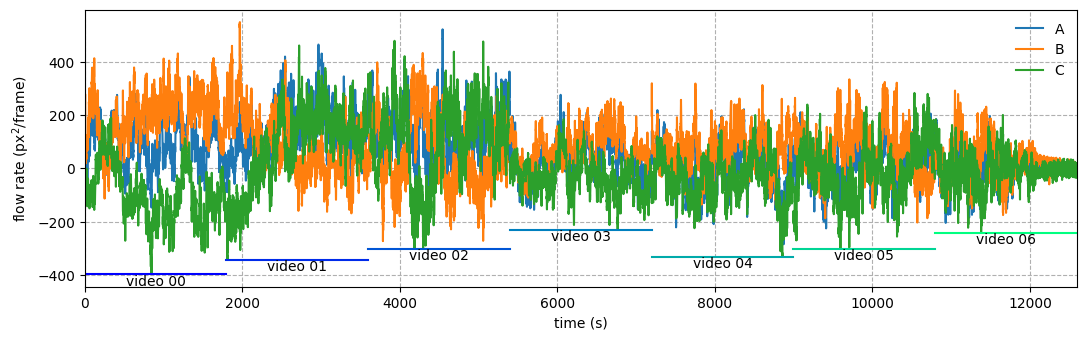

In [6]:
folder = r"A:\SYMMETRIC\19 jan 2023\Flow_rate"
files = ["{:02d}.csv".format(i) for i in range(0, 7)]
colors = plt.cm.get_cmap("tab10")
video_colors = plt.cm.get_cmap("winter", len(files))

plt.figure(figsize=(12.8, 3.6), dpi=100)
offset = 0
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    flowrate.dropna(subset="A", inplace=True)
    for i, channel_name in enumerate(flowrate.drop(columns=["t"])):
        if num == 0:
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors(i), label=channel_name)
        else:
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors(i))
    # video indicator
    offset0 = offset
    offset += flowrate["t"].max()
    y = flowrate.drop(columns=["t"]).min().min()
    plt.plot([offset0, offset], [y, y], color=video_colors(num))
    plt.annotate("video {:02d}".format(num), ((offset0+offset)/2, y), xycoords="data", 
                horizontalalignment="center", verticalalignment="top")
plt.grid(True, ls="--")
plt.legend(frameon=False)
plt.xlabel("time (s)")
plt.ylabel("flow rate (px$^2$/frame)")
plt.xlim([0, offset])

The above plot shows the flow rate evolution in a fully symmetric bifurcation channel for about 3 hours. At around 5500 s, the first sample became inactive and the second sample was loaded. We notice two things:

- long-time flow rate variation is the nature of active nematics in channels: this can be seen in the time ranges [200, 400], [1800, 2000] and many more. In the plot this 200 s period look very short, but think about it, 200 s is not at all short for an active nematic system, whose intrinsic time scale is on the order ot 10 seconds. Rather than artifact or unstable regime, I believe this is part of the nature of AN in channels we need to consider. [0, 0, 0] is also a possible configuration.
- Different samples can have drastically different overall activity: this can be seen from the obvious magnitude difference between the two samples. The first sample have max velocity fluctuating around 400, while the second sample has only ~200.

If we zoom in the [200, 400] regime:

(-500.0, 500.0)

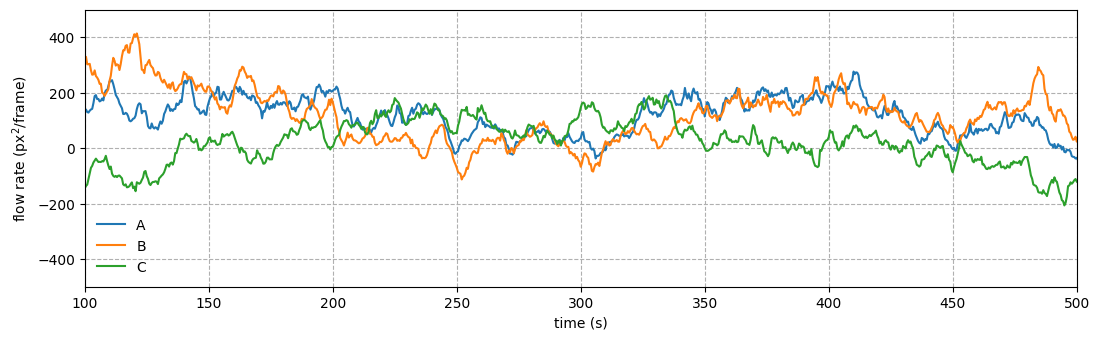

In [14]:
folder = r"A:\SYMMETRIC\19 jan 2023\Flow_rate"
files = ["{:02d}.csv".format(i) for i in range(0, 7)]
colors = plt.cm.get_cmap("tab10")
video_colors = plt.cm.get_cmap("winter", len(files))

plt.figure(figsize=(12.8, 3.6), dpi=100)
offset = 0
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    flowrate.dropna(subset="A", inplace=True)
    for i, channel_name in enumerate(flowrate.drop(columns=["t"])):
        if num == 0:
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors(i), label=channel_name)
        else:
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors(i))
    # video indicator
    offset0 = offset
    offset += flowrate["t"].max()

plt.grid(True, ls="--")
plt.legend(frameon=False)
plt.xlabel("time (s)")
plt.ylabel("flow rate (px$^2$/frame)")
plt.xlim([100, 500])
plt.ylim([-500, 500])

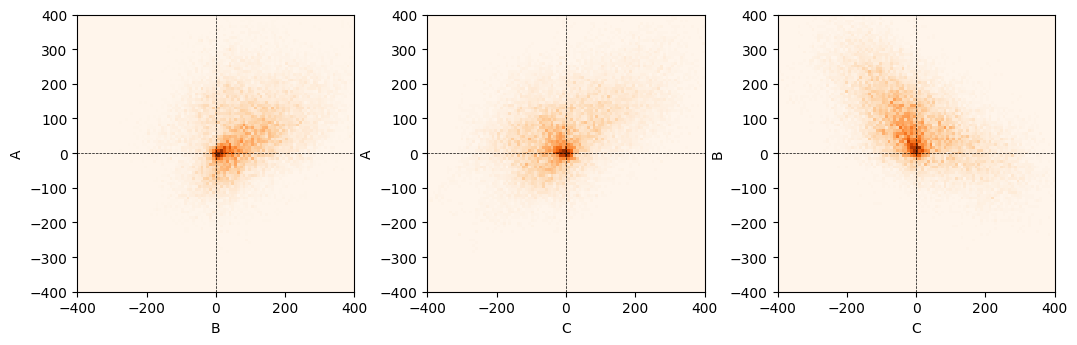

In [10]:
folder = r"A:\SYMMETRIC\19 jan 2023\Flow_rate"
files = ["{:02d}.csv".format(i) for i in range(0, 7)]
# colors = plt.cm.get_cmap("tab10")
# video_colors = plt.cm.get_cmap("winter", len(files))

fig, ax = plt.subplots(ncols=3, figsize=(12.8, 3.6), dpi=100)
fr_list = []
lim = 400
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    fr_list.append(flowrate)
combined = pd.concat(fr_list)
for num, i1, i2 in ((0, "A", "B"), (1, "A", "C"), (2, "B", "C")):
    H, xedges, yedges = np.histogram2d(combined[i1], combined[i2], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
    ax[num].imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax[num].plot([-lim, lim], [0, 0], ls="--", lw=0.5, color="black")
    ax[num].plot([0, 0], [-lim, lim], ls="--", lw=0.5, color="black")
    ax[num].set_xlim([-lim, lim])
    ax[num].set_ylim([-lim, lim])
    ax[num].set_xlabel(i2)
    ax[num].set_ylabel(i1)

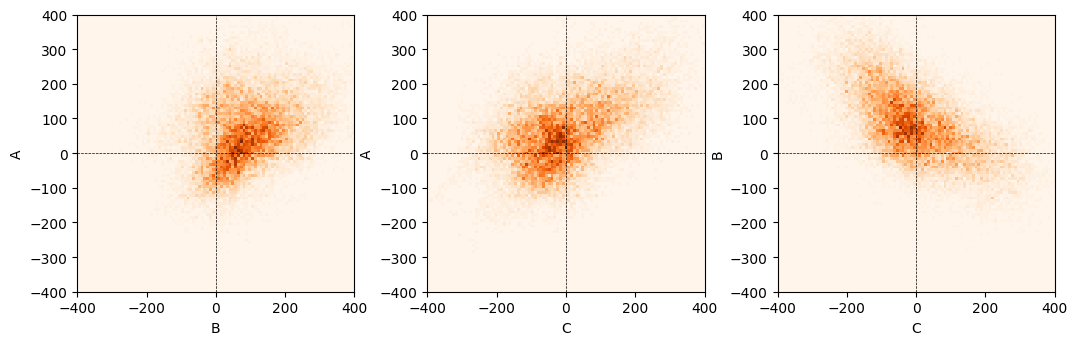

In [57]:
folder = r"A:\SYMMETRIC\19 jan 2023\Flow_rate"
files = ["{:02d}.csv".format(i) for i in range(0, 7)]
# colors = plt.cm.get_cmap("tab10")
# video_colors = plt.cm.get_cmap("winter", len(files))
window_size = 50

fig, ax = plt.subplots(ncols=3, figsize=(12.8, 3.6), dpi=100)
fr_list = []
lim = 400
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    normalizer = uniform_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), size=window_size, axis=0)
    flowrate["normalizer"] = normalizer
    flowrate = flowrate.loc[flowrate.normalizer>50]
    # flowrate["B"] = np.nan
    flowrate.dropna(subset=["A"], inplace=True)
    fr_list.append(flowrate)
combined = pd.concat(fr_list)
for num, i1, i2 in ((0, "A", "B"), (1, "A", "C"), (2, "B", "C")):
    H, xedges, yedges = np.histogram2d(combined[i1], combined[i2], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
    ax[num].imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax[num].plot([-lim, lim], [0, 0], ls="--", lw=0.5, color="black")
    ax[num].plot([0, 0], [-lim, lim], ls="--", lw=0.5, color="black")
    ax[num].set_xlim([-lim, lim])
    ax[num].set_ylim([-lim, lim])
    ax[num].set_xlabel(i2)
    ax[num].set_ylabel(i1)

What does the time series of thresholded flow rate look like?

(-500.0, 500.0)

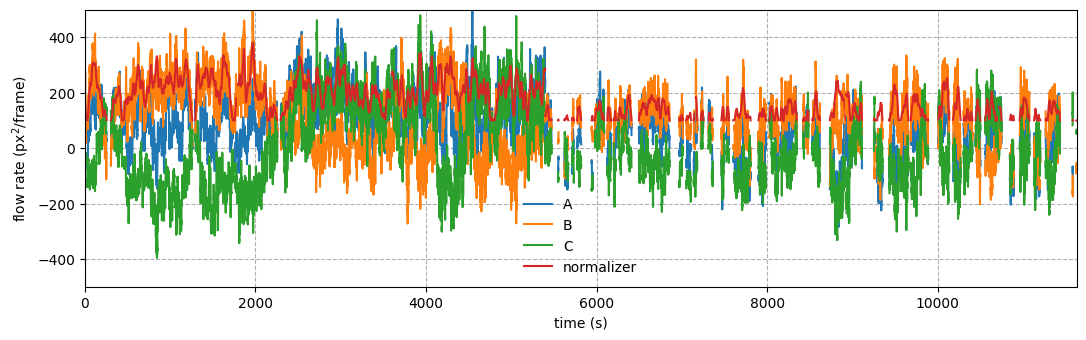

In [36]:
folder = r"A:\SYMMETRIC\19 jan 2023\Flow_rate"
files = ["{:02d}.csv".format(i) for i in range(0, 7)]
colors = plt.cm.get_cmap("tab10")
video_colors = plt.cm.get_cmap("winter", len(files))

plt.figure(figsize=(12.8, 3.6), dpi=100)
offset = 0
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    normalizer = uniform_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), size=window_size, axis=0)
    flowrate["normalizer"] = normalizer
    flowrate.loc[flowrate.normalizer<100] = np.nan
    # flowrate.dropna(subset="A", inplace=True)
    for i, channel_name in enumerate(flowrate.drop(columns=["t"])):
        if num == 0:
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors(i), label=channel_name)
        else:
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors(i))
    # video indicator
    offset0 = offset
    offset += flowrate["t"].max()

plt.grid(True, ls="--")
plt.legend(frameon=False)
plt.xlabel("time (s)")
plt.ylabel("flow rate (px$^2$/frame)")
plt.xlim([0, offset])
plt.ylim([-500, 500])

Normalize flow rate with maximum of average flow rate in a time window.

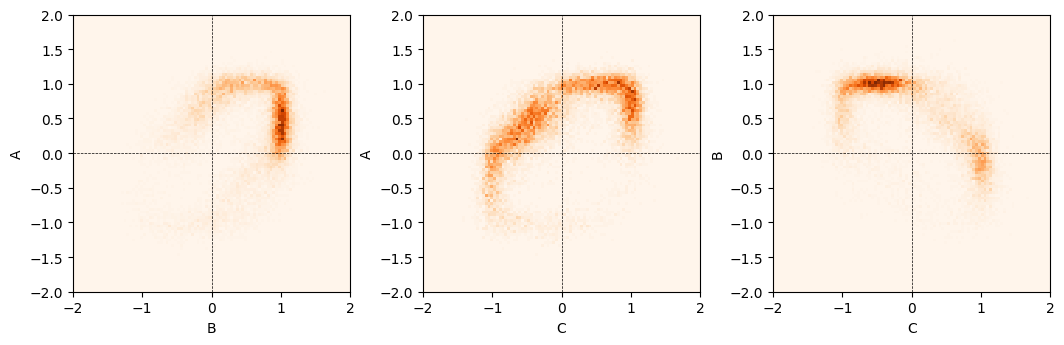

In [41]:
window_size = 10 # frames, 1 frame = 0.5 s

folder = r"A:\SYMMETRIC\19 jan 2023\Flow_rate"
files = ["{:02d}.csv".format(i) for i in range(0, 7)]
# colors = plt.cm.get_cmap("tab10")
# video_colors = plt.cm.get_cmap("winter", len(files))

fig, ax = plt.subplots(ncols=3, figsize=(12.8, 3.6), dpi=100)
fr_list = []
lim = 2
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    # flowrate["B"] = np.nan
    flowrate.dropna(subset="A", inplace=True)
    normalizer = uniform_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), size=window_size, axis=0)
    flowrate["normalizer"] = normalizer
    flowrate = flowrate.loc[flowrate.normalizer>100]
    fr_list.append(flowrate)
combined = pd.concat(fr_list)
for num, i1, i2 in ((0, "A", "B"), (1, "A", "C"), (2, "B", "C")):
    H, xedges, yedges = np.histogram2d(combined[i1]/combined["normalizer"], combined[i2]/combined["normalizer"], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
    ax[num].imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax[num].plot([-lim, lim], [0, 0], ls="--", lw=0.5, color="black")
    ax[num].plot([0, 0], [-lim, lim], ls="--", lw=0.5, color="black")
    ax[num].set_xlim([-lim, lim])
    ax[num].set_ylim([-lim, lim])
    ax[num].set_xlabel(i2)
    ax[num].set_ylabel(i1)

Visualize the effect of window size. 

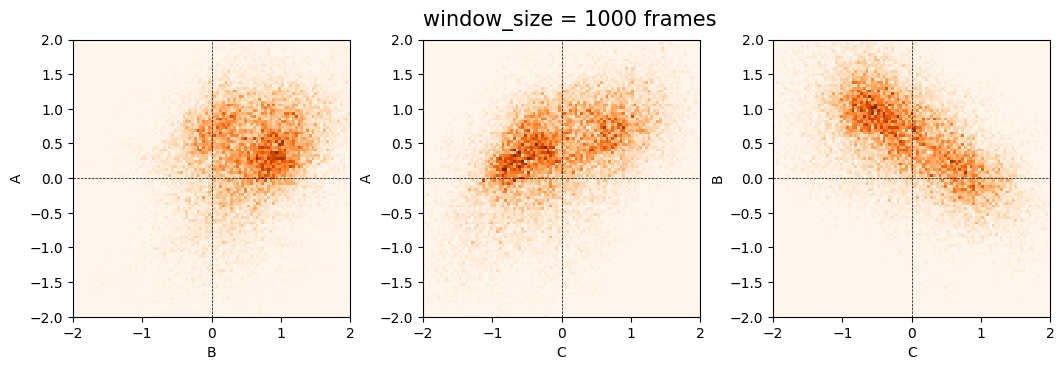

In [59]:
folder = r"A:\SYMMETRIC\19 jan 2023\Flow_rate"
save_folder = r"C:\Users\liuzy\Downloads\wseff"
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)
files = ["{:02d}.csv".format(i) for i in range(0, 7)]
# colors = plt.cm.get_cmap("tab10")
# video_colors = plt.cm.get_cmap("winter", len(files))

for window_size in np.logspace(0, 3):
    window_size = int(window_size)
    fig, ax = plt.subplots(ncols=3, figsize=(12.8, 3.6), dpi=100)
    fr_list = []
    lim = 2
    for num, file in enumerate(files):
        flowrate = pd.read_csv(os.path.join(folder, file))
        # flowrate["B"] = np.nan
        flowrate.dropna(subset="A", inplace=True)
        normalizer = uniform_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), size=window_size, axis=0)
        flowrate["normalizer"] = normalizer
        flowrate = flowrate.loc[flowrate.normalizer>100]
        fr_list.append(flowrate)
    combined = pd.concat(fr_list)
    for num, i1, i2 in ((0, "A", "B"), (1, "A", "C"), (2, "B", "C")):
        H, xedges, yedges = np.histogram2d(combined[i1]/combined["normalizer"], combined[i2]/combined["normalizer"], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
        ax[num].imshow(H, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
        ax[num].plot([-lim, lim], [0, 0], ls="--", lw=0.5, color="black")
        ax[num].plot([0, 0], [-lim, lim], ls="--", lw=0.5, color="black")
        ax[num].set_xlim([-lim, lim])
        ax[num].set_ylim([-lim, lim])
        ax[num].set_xlabel(i2)
        ax[num].set_ylabel(i1)
    ax[1].annotate("window_size = {} frames".format(window_size), (0, 1.05), xycoords="axes fraction", fontsize=15)
    # fig.savefig(os.path.join(save_folder, "{:d}.jpg".format(window_size)))
    # plt.close()
    plt.pause(.1)
    clear_output(wait=True)

## 2 Illustrate the process

1. Determine the normalizer

(0.0, 1000.0)

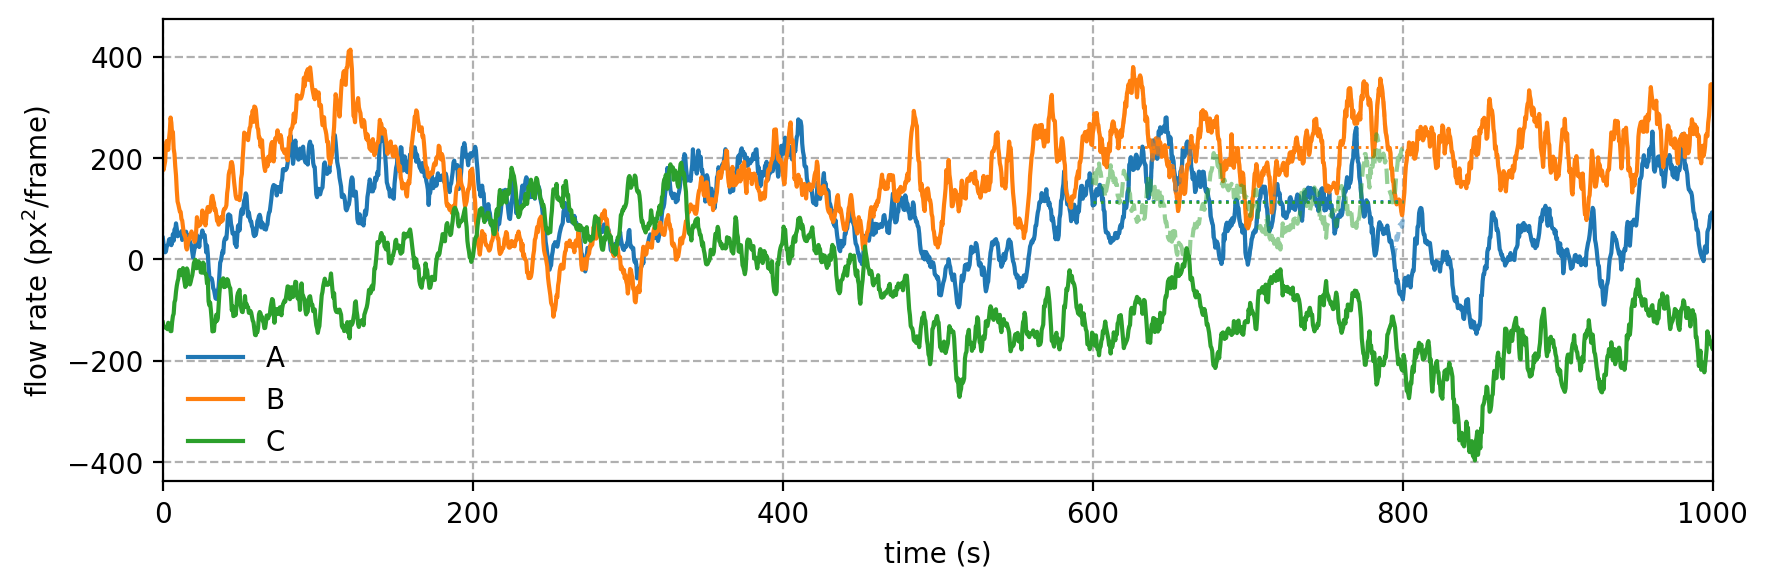

In [ ]:
folder = r"A:\SYMMETRIC\19 jan 2023\Flow_rate"
files = ["{:02d}.csv".format(i) for i in range(0, 1)]
colors = plt.cm.get_cmap("tab10")
video_colors = plt.cm.get_cmap("winter", len(files))

plt.figure(figsize=(10, 3), dpi=200)
offset = 0
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    tmp = flowrate.loc[1200:1600].copy()
    tmp.loc[:, ["A", "B", "C"]] = tmp.loc[:, ["A", "B", "C"]].abs()
    if num == 0:
        plt.plot(flowrate.t + offset, flowrate.A, color=colors(0), label="A")
        plt.plot(flowrate.t + offset, flowrate.B, color=colors(1), label="B")
        plt.plot(flowrate.t + offset, flowrate.C, color=colors(2), label="C")
    else:
        plt.plot(flowrate.t + offset, flowrate.A, color=colors(0))
        plt.plot(flowrate.t + offset, flowrate.B, color=colors(1))
        plt.plot(flowrate.t + offset, flowrate.C, color=colors(2))

    plt.plot(tmp.t + offset, tmp.A, color=colors(0), ls="--", alpha=0.5)
    plt.plot(tmp.t + offset, tmp.B, color=colors(1), ls="--", alpha=0.5)
    plt.plot(tmp.t + offset, tmp.C, color=colors(2), ls="--", alpha=0.5)

    plt.plot([600, 800], [tmp.A.mean(), tmp.A.mean()], color=colors(0), ls=":", lw=1)
    plt.plot([600, 800], [tmp.B.mean(), tmp.B.mean()], color=colors(1), ls=":", lw=1)
    plt.plot([600, 800], [tmp.C.mean(), tmp.C.mean()], color=colors(2), ls=":", lw=1)
    # video indicator

    # y = flowrate[["A", "B", "C"]].min().min()
    # plt.plot([offset0, offset], [y, y], color=video_colors(num))
    # plt.annotate("video {:02d}".format(num), ((offset0+offset)/2, y), xycoords="data", 
    #             horizontalalignment="center", verticalalignment="top")
plt.grid(True, ls="--")
plt.legend(frameon=False)
plt.xlabel("time (s)")
plt.ylabel("flow rate (px$^2$/frame)")
plt.xlim([0, 1000])

2. Normalized flow rate ($w=200$ s)

(0.0, 1000.0)

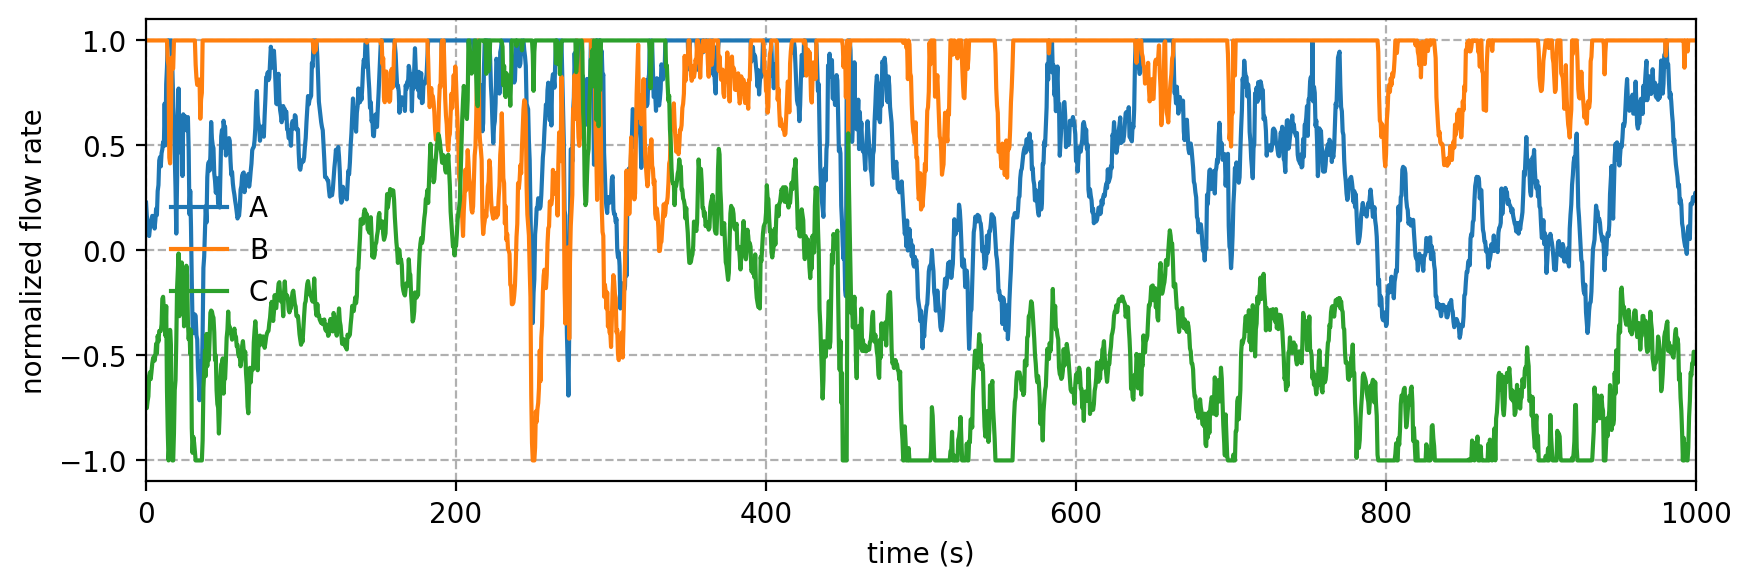

In [ ]:
folder = r"A:\SYMMETRIC\19 jan 2023\Flow_rate"
files = ["{:02d}.csv".format(i) for i in range(0, 1)]
colors = plt.cm.get_cmap("tab10")
video_colors = plt.cm.get_cmap("winter", len(files))
window_size = 1

plt.figure(figsize=(10, 3), dpi=200)
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    for start in range(0, len(flowrate), window_size):
        normalizer = flowrate.loc[start: start+window_size-1, ["A", "B", "C"]].abs().mean(axis=0).max()
        flowrate.loc[start: start+window_size-1, ["A", "B", "C"]] /= normalizer
    if num == 0:
        plt.plot(flowrate.t + offset, flowrate.A, color=colors(0), label="A")
        plt.plot(flowrate.t + offset, flowrate.B, color=colors(1), label="B")
        plt.plot(flowrate.t + offset, flowrate.C, color=colors(2), label="C")
    else:
        plt.plot(flowrate.t + offset, flowrate.A, color=colors(0))
        plt.plot(flowrate.t + offset, flowrate.B, color=colors(1))
        plt.plot(flowrate.t + offset, flowrate.C, color=colors(2))

plt.grid(True, ls="--")
plt.legend(frameon=False)
plt.xlabel("time (s)")
plt.ylabel("normalized flow rate")
plt.xlim([0, 1000])

3. Show normalizer

(0.0, 1000.0)

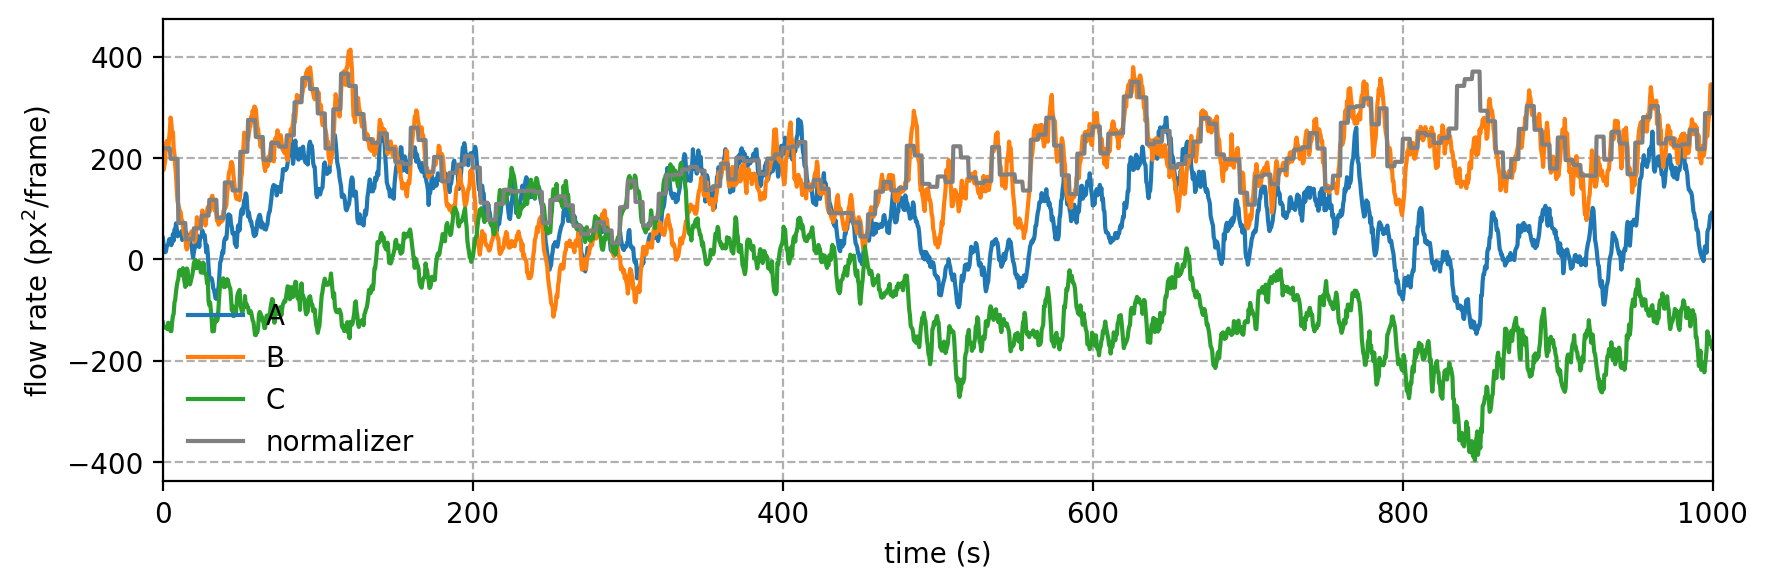

In [ ]:
folder = r"A:\SYMMETRIC\19 jan 2023\Flow_rate"
files = ["{:02d}.csv".format(i) for i in range(0, 1)]
colors = plt.cm.get_cmap("tab10")
video_colors = plt.cm.get_cmap("winter", len(files))
window_size = 10 # frames, 1 frame = 0.5 s


plt.figure(figsize=(10, 3), dpi=200)
offset = 0
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    for start in range(0, len(flowrate), window_size):
        normalizer = flowrate.loc[start: start+window_size, ["A", "B", "C"]].abs().mean(axis=0).max()
        flowrate.loc[start: start+window_size, "normalizer"] = normalizer
    if num == 0:
        plt.plot(flowrate.t + offset, flowrate.A, color=colors(0), label="A")
        plt.plot(flowrate.t + offset, flowrate.B, color=colors(1), label="B")
        plt.plot(flowrate.t + offset, flowrate.C, color=colors(2), label="C")
    else:
        plt.plot(flowrate.t + offset, flowrate.A, color=colors(0))
        plt.plot(flowrate.t + offset, flowrate.B, color=colors(1))
        plt.plot(flowrate.t + offset, flowrate.C, color=colors(2))

    plt.plot(flowrate.t + offset, flowrate["normalizer"], color="gray", label="normalizer")

    # video indicator

    # y = flowrate[["A", "B", "C"]].min().min()
    # plt.plot([offset0, offset], [y, y], color=video_colors(num))
    # plt.annotate("video {:02d}".format(num), ((offset0+offset)/2, y), xycoords="data", 
    #             horizontalalignment="center", verticalalignment="top")
plt.grid(True, ls="--")
plt.legend(frameon=False)
plt.xlabel("time (s)")
plt.ylabel("flow rate (px$^2$/frame)")
plt.xlim([0, 1000])

#### 4.1.3 Average filter

The normalization process described above resembles rescaling raw data by the same data filtered an average filter, which replace EACH data point with the average value in a window. The difference in our approach is that we apply the average filter "block-wise", while typical average filter apply "point-wise". Let's try mean filter here.

Text(0, 0.5, 'normalized flow rate')

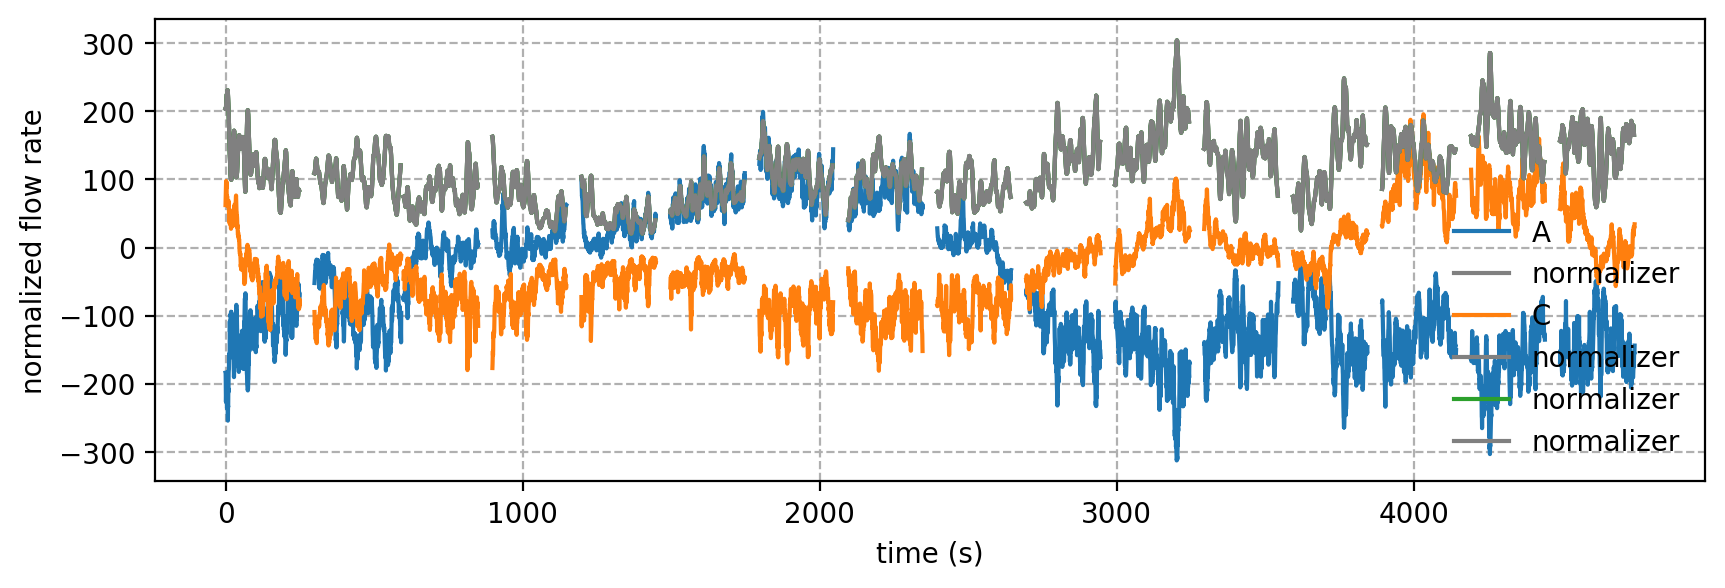

In [ ]:
folder = r"A:\SYMMETRIC\05_july_2022\Flow_rate"
files = ["{:02d}.csv".format(i) for i in range(0, 16)]
colors = plt.cm.get_cmap("tab10")
video_colors = plt.cm.get_cmap("winter", len(files))
window_size = 10
offset = 0
plt.figure(figsize=(10, 3), dpi=200)
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    flowrate["normalizer"] = uniform_filter1d(flowrate.drop(columns=["t"]).abs().max(axis=1), size=window_size, axis=0)
    for i, kw in enumerate(flowrate.drop(columns=["t"])):
        if num == 0:            
            plt.plot(flowrate.t + offset, flowrate[kw], color=colors(i), label=kw)
            plt.plot(flowrate.t + offset, flowrate["normalizer"], color="gray", label="normalizer")
        else:
            plt.plot(flowrate.t + offset, flowrate[kw], color=colors(i))
            plt.plot(flowrate.t + offset, flowrate["normalizer"], color="gray")
        
    offset += flowrate["t"].max()
plt.grid(True, ls="--")
plt.legend(frameon=False)
plt.xlabel("time (s)")
plt.ylabel("normalized flow rate")
# plt.xlim([0, 100])

Histogram.

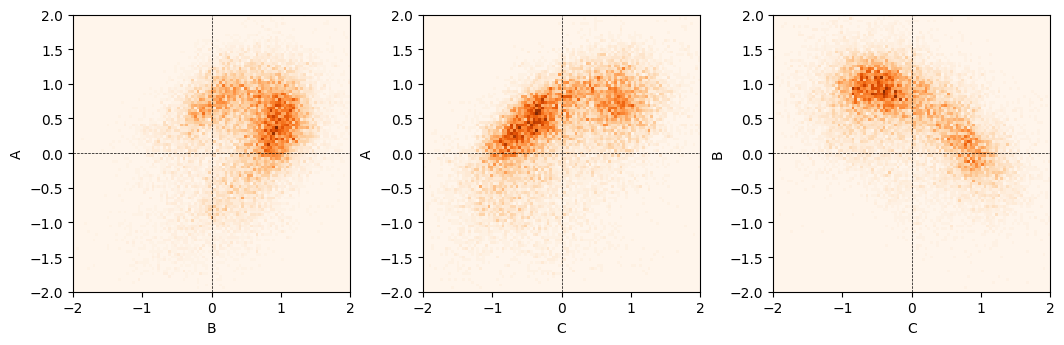

In [ ]:
window_size = 100 # frames, 1 frame = 0.5 s

folder = r"A:\SYMMETRIC\19 jan 2023\Flow_rate"
files = ["{:02d}.csv".format(i) for i in range(0, 6)]
# colors = plt.cm.get_cmap("tab10")
# video_colors = plt.cm.get_cmap("winter", len(files))

fig, ax = plt.subplots(ncols=3, figsize=(12.8, 3.6), dpi=100)
fr_list = []
lim = 2
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    normalizer = uniform_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), size=window_size, axis=0)
    flowrate["normalizer"] = normalizer
    fr_list.append(flowrate)
combined = pd.concat(fr_list)
for num, i1, i2 in ((0, "A", "B"), (1, "A", "C"), (2, "B", "C")):
    H, xedges, yedges = np.histogram2d(combined[i1]/combined["normalizer"], combined[i2]/combined["normalizer"], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
    ax[num].imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax[num].plot([-lim, lim], [0, 0], ls="--", lw=0.5, color="black")
    ax[num].plot([0, 0], [-lim, lim], ls="--", lw=0.5, color="black")
    ax[num].set_xlim([-lim, lim])
    ax[num].set_ylim([-lim, lim])
    ax[num].set_xlabel(i2)
    ax[num].set_ylabel(i1)